# Car Prediction

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [769]:
data = pd.read_excel('Data_Train.xlsx')

In [770]:
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


## Splitting Data

In [771]:
from sklearn.model_selection import train_test_split

In [772]:
y = data['Price'].values
X = data.drop('Price', axis = 'columns')

In [773]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 3)

## Data Formatting Helper Functions

In [774]:
def mileage_format(X, mean):
    mileage_df = X['Mileage'].str.split(" ", expand = True)
    
    #Adding two columns
    mileage_df['Mileage_kmpl'] = 0.0
    mileage_df['Mileage_km/kg'] = 0.0

    #Filling these two columns
    mileage_df.loc[mileage_df[1]=='kmpl', 'Mileage_kmpl'] = mileage_df.loc[mileage_df[1] == 'kmpl', 0]
    mileage_df.loc[mileage_df[1]=='km/kg', 'Mileage_km/kg'] = mileage_df.loc[mileage_df[1] == 'km/kg', 0]
    
    #merging these two
    mileage_df.drop([0,1], axis = 'columns', inplace = True)
    X_new = pd.concat([X, mileage_df], axis = 'columns')
    
    #Deleting extra columns
    X_new.drop('Mileage', axis = 'columns', inplace = True)
    
    #Converting to float
    X_new[['Mileage_kmpl', 'Mileage_km/kg']] = X_new[['Mileage_kmpl', 'Mileage_km/kg']].astype(float)
    
    #Missing value to average
    X_new.loc[X_new['Mileage_kmpl'] == 0.0, 'Mileage_kmpl'] = mean
    
    return X_new

In [775]:
def engine_transform(X, mean):
    #Splitting into float values
    engine_df = X['Engine'].str.split(" CC", expand = True)
    
    #Convert to float
    engine_df[0] = engine_df[0].astype(float)
    
    #Log transform feature
    engine_df['Engine_log'] = np.log(1 + engine_df[0].values)
    
    #Inputting missing feature
    engine_df['Engine_log'].fillna(mean, inplace = True)
    
    #Merging columns
    X = pd.concat([X, engine_df], axis = 'columns')
    
    #Deleting useless features
    X.drop([0,1, 'Engine'], axis = 'columns', inplace = True)
    
    return X

In [776]:
def power_transform(X, mean):
    
    #Splitting
    power_df = X['Power'].str.split(" bhp", expand = True)[0]
    
    #Some values contains the value null: Making it NaN
    power_df[power_df == 'null'] = np.nan
    
    #Converting to float
    power_df = power_df.astype(float)
    
    #Log transformation
    power_log = np.log(1 + power_df)
    
    #Missing value
    power_log.fillna(mean, inplace = True)
    
    #Merging
    X['Power_log'] = power_log
    
    #Deleteing
    X.drop('Power', axis='columns', inplace = True)
    
    return X

In [777]:
def seat_transform(X, mode):
    X['Seats'].fillna(mode, inplace = True)
    return X

In [778]:
def newPrice_transform(X):
    X.drop('New_Price', axis = 'columns', inplace = True)
    return X

In [779]:
def format_names(X):
    first_name = X['Name'].str.split().str.get(0)
    
    X['Name'] = first_name
    
    #X.drop('Name', axis='columns', inplace = True)
    
    return X

In [780]:
def owner_transform(X):
    
    mapp = {'First':1,
           'Second':2,
           'Third':3,
           'Fourth & Above':4}
    
    X['Owner_Type'] = X['Owner_Type'].map(mapp)
    
    return X

In [781]:
def kilometers_transform(X):
    X['Kilometers_log'] = np.log(X['Kilometers_Driven'])
    X.drop('Kilometers_Driven', axis = 'columns', inplace = True)
    
    return X

In [782]:
class data_format(object):
    
    def fit(self, X):
        #MILEAGE
        mileage_df = X['Mileage'].str.split(" ", expand = True)

        #Adding two columns
        mileage_df['Mileage_kmpl'] = 0.0

        #Filling these two columns
        mileage_df.loc[mileage_df[1]=='kmpl', 'Mileage_kmpl'] = mileage_df.loc[mileage_df[1] == 'kmpl', 0]

        #Converting to float
        mileage_df['Mileage_kmpl'] = mileage_df['Mileage_kmpl'].astype(float)
        
        self.mileage_mean = mileage_df['Mileage_kmpl'].mean()
        
        
        #ENGINE
        #Splitting into float values
        engine_df = X['Engine'].str.split(" CC", expand = True)

        #Convert to float
        engine_df[0] = engine_df[0].astype(float)

        #Log transform feature
        engine_df['Engine_log'] = np.log(1 + engine_df[0].values)
        
        self.engine_mean = engine_df['Engine_log'].mean()
        
        #POWER
        #Splitting
        power_df = X['Power'].str.split(" bhp", expand = True)[0]

        #Some values contains the value null: Making it NaN
        power_df[power_df == 'null'] = np.nan

        #Converting to float
        power_df = power_df.astype(float)

        #Log transformation
        power_log = np.log(1 + power_df)
        
        self.power_mean = power_log.mean()
        
        self.moce = 5.0
        
        
        
    
    def transform(self,X):
        X = mileage_format(X, self.mileage_mean)
        X = engine_transform(X, self.engine_mean)
        X = power_transform(X, self.power_mean)
        X = seat_transform(X, 5.0)
        X = newPrice_transform(X)
        X = format_names(X)
        X = owner_transform(X)
        X = kilometers_transform(X)
        
        return X

In [783]:
frmt = data_format()

In [784]:
frmt.fit(X_train)

In [785]:
X_train = frmt.transform(X_train)

In [786]:
X_train.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log
2957,Nissan,Ahmedabad,2016,Petrol,Manual,1,5.0,19.69,0.0,7.089243,4.220096,10.621327
1602,Maruti,Hyderabad,2011,Petrol,Manual,1,4.0,16.10,0.0,6.680855,3.637586,11.338203
5018,Honda,Hyderabad,2017,Diesel,Manual,1,5.0,27.30,0.0,7.312553,4.601162,9.749812
2181,Maruti,Mumbai,2008,Petrol,Manual,1,5.0,19.70,0.0,6.680855,3.856510,10.177286
2919,Volkswagen,Jaipur,2013,Diesel,Manual,1,5.0,20.54,0.0,7.377134,4.650144,11.877569


In [787]:
X_test = frmt.transform(X_test)

In [788]:
X_test.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log
1741,BMW,Hyderabad,2013,Diesel,Automatic,1,4.0,11.20,0.0,8.004366,5.726848,10.968198
2667,Tata,Mumbai,2017,Petrol,Manual,1,5.0,17.57,0.0,7.085064,4.496471,11.512925
3063,Maruti,Jaipur,2016,Diesel,Manual,1,5.0,26.21,0.0,7.130099,4.494239,11.339583
610,Hyundai,Coimbatore,2017,Diesel,Manual,1,5.0,23.90,0.0,7.367077,4.845761,10.546814
3510,Hyundai,Mumbai,2016,Petrol,Automatic,1,5.0,13.00,0.0,7.372746,4.806477,10.203592


In [789]:
X_test.isnull().any()

Name              False
Location          False
Year              False
Fuel_Type         False
Transmission      False
Owner_Type        False
Seats             False
Mileage_kmpl      False
Mileage_km/kg     False
Engine_log        False
Power_log         False
Kilometers_log    False
dtype: bool

**Works well mostly**

## Rescaling

- Year: MinMax
- Owner_Type : MinMax
- Seats: MinMax
- Mileage_kmpl: Standard
- Mileage_km/kg : Standard
- Engine_log: Standard
- Power_log : Standard
- Kilometers_log: Standard

In [790]:
##Rescaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [791]:
mmScaler = MinMaxScaler()

In [792]:
X_train.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log
2957,Nissan,Ahmedabad,2016,Petrol,Manual,1,5.0,19.69,0.0,7.089243,4.220096,10.621327
1602,Maruti,Hyderabad,2011,Petrol,Manual,1,4.0,16.10,0.0,6.680855,3.637586,11.338203
5018,Honda,Hyderabad,2017,Diesel,Manual,1,5.0,27.30,0.0,7.312553,4.601162,9.749812
2181,Maruti,Mumbai,2008,Petrol,Manual,1,5.0,19.70,0.0,6.680855,3.856510,10.177286
2919,Volkswagen,Jaipur,2013,Diesel,Manual,1,5.0,20.54,0.0,7.377134,4.650144,11.877569


In [793]:
X_test.head()

,Name,Location,Year,Fuel_Type,Transmission,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log
1741,BMW,Hyderabad,2013,Diesel,Automatic,1,4.0,11.20,0.0,8.004366,5.726848,10.968198
2667,Tata,Mumbai,2017,Petrol,Manual,1,5.0,17.57,0.0,7.085064,4.496471,11.512925
3063,Maruti,Jaipur,2016,Diesel,Manual,1,5.0,26.21,0.0,7.130099,4.494239,11.339583
610,Hyundai,Coimbatore,2017,Diesel,Manual,1,5.0,23.90,0.0,7.367077,4.845761,10.546814
3510,Hyundai,Mumbai,2016,Petrol,Automatic,1,5.0,13.00,0.0,7.372746,4.806477,10.203592


## Some Visualizing

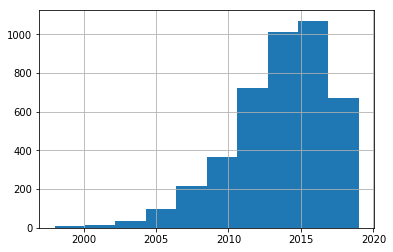

In [794]:
X_train['Year'].hist()

# X_train['Owner_Type'].hist()

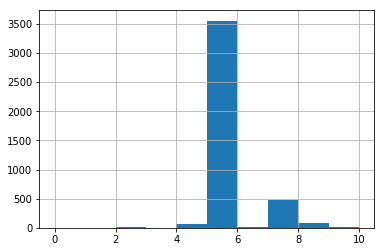

In [795]:
X_train['Seats'].hist()

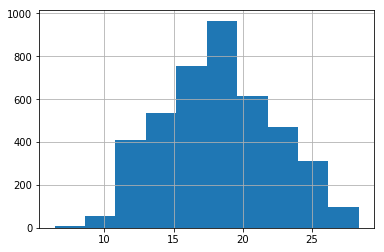

In [796]:
X_train['Mileage_kmpl'].hist()

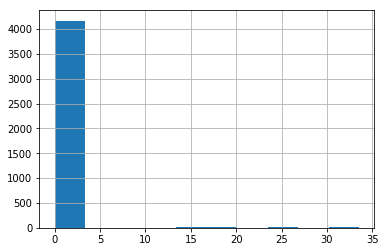

In [797]:
X_train['Mileage_km/kg'].hist()

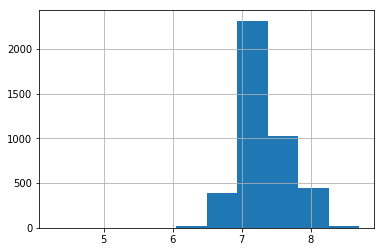

In [798]:
X_train['Engine_log'].hist()

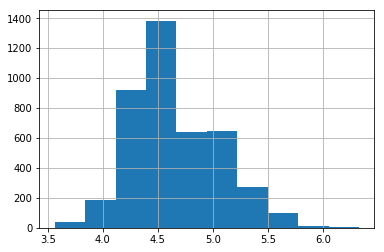

In [799]:
X_train['Power_log'].hist()

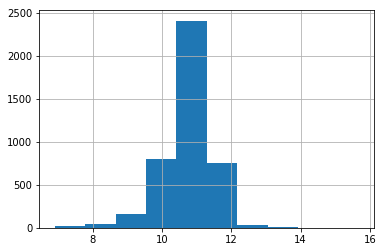

In [800]:
X_train['Kilometers_log'].hist()

## One Hot Encoding

In [801]:
X = pd.concat([X_train, X_test], axis = 0)

In [802]:
categorical_features = ['Name','Location', 'Fuel_Type', 'Transmission']

In [803]:
X_hot = pd.get_dummies(X, categorical_features)

In [804]:
X_hot.head()

,Year,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log,Name_Ambassador,Name_Audi,...,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
2957,2016,1,5.0,19.69,0.0,7.089243,4.220096,10.621327,0,0,...,0,0,0,0,0,0,0,1,0,1
1602,2011,1,4.0,16.10,0.0,6.680855,3.637586,11.338203,0,0,...,0,0,0,0,0,0,0,1,0,1
5018,2017,1,5.0,27.30,0.0,7.312553,4.601162,9.749812,0,0,...,0,0,0,0,1,0,0,0,0,1
2181,2008,1,5.0,19.70,0.0,6.680855,3.856510,10.177286,0,0,...,0,1,0,0,0,0,0,1,0,1
2919,2013,1,5.0,20.54,0.0,7.377134,4.650144,11.877569,0,0,...,0,0,0,0,1,0,0,0,0,1


In [805]:
X_train = X_hot.iloc[X_train.index]

In [806]:
X_test = X_hot.iloc[X_test.index]

In [807]:
X_train.head()

,Year,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log,Name_Ambassador,Name_Audi,...,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
2330,2012,1,5.0,16.25,0.0,7.089243,4.330733,10.204111,0,0,...,0,1,0,0,0,0,0,1,0,1
2870,2014,1,5.0,18.00,0.0,7.089243,4.473922,10.708914,0,0,...,0,0,0,0,0,0,0,1,0,1
2658,2015,1,5.0,21.66,0.0,7.312553,4.649378,11.099257,0,0,...,0,0,0,0,1,0,0,0,1,0
792,2008,2,7.0,13.10,0.0,7.824046,4.955827,12.230765,0,0,...,0,0,0,0,1,0,0,0,0,1
4870,2011,3,7.0,16.00,0.0,7.687080,4.948760,11.759786,0,0,...,0,0,0,0,1,0,0,0,0,1


In [808]:
X_test.head()

,Year,Owner_Type,Seats,Mileage_kmpl,Mileage_km/kg,Engine_log,Power_log,Kilometers_log,Name_Ambassador,Name_Audi,...,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
2111,2017,1,5.0,17.90,0.0,7.670429,5.309010,10.150387,0,0,...,0,0,0,0,1,0,0,0,1,0
5989,2013,2,5.0,18.25,0.0,7.585281,5.240370,10.978985,0,1,...,0,0,0,0,1,0,0,0,1,0
4893,2018,1,2.0,10.37,0.0,7.999679,5.726848,9.205529,0,0,...,0,0,0,0,0,0,0,1,1,0
3347,2017,1,5.0,18.50,0.0,7.088409,4.432482,10.754685,0,0,...,0,0,0,0,0,0,0,1,1,0
4036,2015,1,5.0,23.20,0.0,7.130099,4.316688,10.472035,0,0,...,0,0,0,0,1,0,0,0,0,1


In [809]:
X_train = np.asarray(X_train)

In [810]:
X_test = np.asarray(X_test)

# Model Building

## Make yor own scorer: RMSLE

In [811]:
from sklearn.metrics import make_scorer

In [812]:
def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = (np.log(y_pred + 1) - np.log(y + 1)) ** 2.0
    rmsle =  (np.sum(terms_to_sum) * (1.0/len(y)))** 0.5
    
    return 1 - rmsle

In [813]:
rmsle_scorer = make_scorer(rmsle_score, greater_is_better = True)

## Model1: Ridge Regression

In [814]:
from sklearn.linear_model import Ridge

In [815]:
rdg = Ridge()

In [816]:
rdg.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [817]:
y_pred_train = rdg.predict(X_train)

In [818]:
y_pred_test = rdg.predict(X_test)

In [819]:
rmsle_score(y_train, y_pred_train)

0.18038582874185527

In [820]:
rmsle_score(y_test, y_pred_test)

0.1838988269096724

In [821]:
rdg.score(X_train, y_train)

0.009636211267008088

In [822]:
rdg.score(X_test, y_test)

-0.008831651646862504

## Model 2

In [823]:
from sklearn.ensemble import RandomForestRegressor

In [824]:
rfg = RandomForestRegressor()

In [825]:
rfg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [826]:
y_pred_train = rfg.predict(X_train)

In [827]:
y_pred_test = rfg.predict(X_test)

In [828]:
rmsle_score(y_train, y_pred_train)

0.5494565730913576

In [829]:
rmsle_score(y_test, y_pred_test)

0.10920114503983536

In [830]:
rfg.score(X_train, y_train)

0.7752131549793673

In [831]:
rfg.score(X_test, y_test)

-0.1794501614114119

## SVM Regressor

In [832]:
from sklearn.svm import SVR

In [833]:
svr = SVR()

In [834]:
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [835]:
svr.score(X_train, y_train)

-0.11126781453365742

In [836]:
svr.score(X_test, y_test)

-0.10730048608342457